In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape, Input, Flatten
from sklearn.model_selection import train_test_split

In [2]:
import time, datetime
from fyers_apiv3 import fyersModel
client_id = "ZHQ4IJL7TI-100"
with open("access_token", "r") as f:
    access_token = f.read()

fyers = fyersModel.FyersModel(client_id=client_id, is_async=False, token=access_token, log_path="")

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os

In [4]:
from indicators.syncind import SyncInd
from indicators.classic import SMA, Alligator, SmoothMA, RSI, MACD, ATR, WMA, EMA, RMA, VolumeROC, KAMA
from indicators.candle import OHLC

In [5]:
model = tf.keras.models.load_model("26NOV_2.keras")
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 8, 200)         │       166,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 150)            │       210,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           755 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 5)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,133,267 (4.32 MB)

 Trainable params: 377,755 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 755,512 (2.88 MB)

In [6]:
date_today = datetime.datetime.now().strftime("%Y-%m-%d")
date_yesterday = (datetime.datetime.now() - datetime.timedelta(days=1)).strftime("%Y-%m-%d")
date_100_p = (datetime.datetime.now() - datetime.timedelta(days=100)).strftime("%Y-%m-%d")
last_candles_count = 8
next_candles_count = 5
date_yesterday, date_100_p

('2024-11-26', '2024-08-19')

In [23]:
# symbol = "NSE:ZEEL-EQ"
symbol = "NSE:NIFTY50-INDEX"
response = fyers.history(data={
                                "symbol": symbol,
                                "resolution": "1",
                                "date_format": "1",
                                "range_from": date_100_p,
                                "range_to": date_today,
                                "cont_flag": "1"
                                })

response['message']

''

In [24]:
date_temp = []
final_candles_list = []
for i in response['candles']:
    if i[0] not in date_temp:
        final_candles_list.append(i)
        date_temp.append(i[0])
del date_temp
len(final_candles_list)

25856

In [25]:
candles = np.array(final_candles_list)
candles.shape

(25856, 6)

In [26]:
sync = SyncInd(
    SMA(5),
    # Alligator(show_jaw=False, show_teeth=False)
    KAMA(highlight=True)
)

for c in candles:
    sync.append(c)
sync.data().shape

(25856, 9)

In [27]:
first_candle = sync.data()[-last_candles_count+1]
temp = []
for i in range(last_candles_count, 0, -1):
    temp.append(sync.data()[-i] - first_candle)
final_temp = []
for k in np.array(temp):
    final_temp.append(k[1:5].tolist() + k[6:].tolist())
final_temp = np.array(final_temp)
final_temp.shape

(8, 7)

In [28]:
prediction = model.predict(tf.expand_dims(final_temp, axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


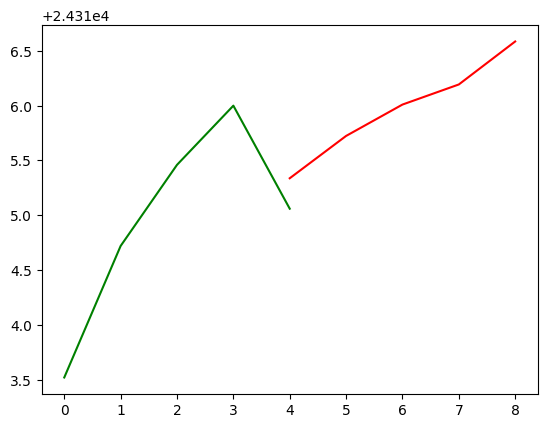

In [29]:
plt.plot(sync.data()[-5:, 6], color="green")
plt.plot([None, None, None, None, ]+[i + first_candle[6] for i in prediction[0]], color="red")
plt.show()

In [30]:
last_d_t = datetime.datetime.fromtimestamp(int(sync.last_candle()[0]))
for ind, i in enumerate([i + first_candle[6] for i in prediction[0]]):
    print(f"{symbol} @ {(last_d_t + datetime.timedelta(minutes=ind+1)).strftime('%H:%M')} ->\t", i, end="\n\n")


NSE:NIFTY50-INDEX @ 14:11 ->	 24315.337600250245

NSE:NIFTY50-INDEX @ 14:12 ->	 24315.72385980606

NSE:NIFTY50-INDEX @ 14:13 ->	 24316.010046977997

NSE:NIFTY50-INDEX @ 14:14 ->	 24316.193422813416

NSE:NIFTY50-INDEX @ 14:15 ->	 24316.585717220307

